In [1]:
# === Dependencies ===
# =======================
# === Cell 1: Imports ===
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# ======================
# === Configuration ===
# ======================
# === Cell 2: Paths and Settings ===
base_dir = r"D:/School/Project/Machine_Learning/Datasets"
train_dir = os.path.join(base_dir, "HardFit")
val_dir = os.path.join(base_dir, "Validation")
model_output_dir = os.path.join(base_dir, "Models")
os.makedirs(model_output_dir, exist_ok=True)

IMG_HEIGHT, IMG_WIDTH = 120, 160
BATCH_SIZE = 16
EPOCHS = 20

retrained_model_path_h5 = os.path.join(model_output_dir, "eleventh.h5")
retrained_model_path_keras = os.path.join(model_output_dir, "eleventh.keras")
tflite_model_path = os.path.join(model_output_dir, "eleventh.tflite")

In [3]:
# ===============================
# === Load Class Names & Data ===
# ===============================
# === Cell 3: Load Class Names ===
model = load_model(os.path.join(base_dir, "tenth.h5"))
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(f"Loaded model with classes: {class_names}")



Loaded model with classes: ['Grass_Paths', 'Gravel_Stony', 'Murram', 'Pavements', 'Stairs', 'Tarmac', 'Tiles']


In [4]:
# ==============================
# === Compile Model ======
# ==============================
# === Cell 4: Load and Compile Pretrained Model ===
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),  # static starting LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [5]:
# ===================================
# === Advanced Data Augmentation ===
# ===================================
# === Cell 5: Data Generators with Augmentation ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4584 images belonging to 7 classes.
Found 453 images belonging to 7 classes.


In [6]:
# ======================
# === Class Weights ====
# ======================
# === Cell 6: Compute Class Weights ===
labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))


In [7]:
# ==========================
# === Training Callbacks ===
# ==========================
# === Cell 7: Callbacks ===
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(base_dir, 'best_finetuned_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [reduce_lr, early_stop, checkpoint]

In [8]:
# =======================
# === Model Training ====
# =======================
# === Cell 8: Retrain the Model ===
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

C:\Users\manas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.8483 - loss: 0.3965
Epoch 1: val_accuracy improved from -inf to 0.85210, saving model to D:/School/Project/Machine_Learning/Datasets\best_finetuned_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 221s 755ms/step - accuracy: 0.8483 - loss: 0.3965 - val_accuracy: 0.8521 - val_loss: 0.3665 - learning_rate: 1.0000e-04
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.8411 - loss: 0.4268
Epoch 2: val_accuracy improved from 0.85210 to 0.90728, saving model to D:/School/Project/Machine_Learning/Datasets\best_finetuned_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 195s 681ms/step - accuracy: 0.8411 - loss: 0.4267 - val_accuracy: 0.9073 - val_loss: 0.2588 - learning_rate: 1.0000e-04
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.8598 - loss: 0.3933
Epoch 3: val_accuracy did not improve from 0.90728
287/287 ━━━━━━━━━━━━━━━━━━━━ 214s 747ms/step - accuracy: 0.8598 - loss: 0.3933 - val_accuracy: 0.8962 - val_loss: 0.2857 - learning_rate: 1.0000e-04
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.8543 - loss: 0.3919
Epoch 4: val_accuracy did not improve from 0.90728
287/287 ━━━━━━━━━━━━━━━━━━━━ 199s 692ms/step - accuracy: 0.8543 - loss: 0.3919 - val_accuracy: 0.8698 - val_loss: 0.3221 - learning_rate: 1.0000e-04
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8629 - loss: 0.3912
Epoch 5: val_accuracy improved from 0.90728 to 0.90949, saving model to D:/School/Project/Machine_Learning/Datasets\best_finetuned_model.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 188s 655ms/step - accuracy: 0.8628 - loss: 0.3912 - val_accuracy: 0.9095 - val_loss: 0.2570 - learning_rate: 1.0000e-04
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.8495 - loss: 0.4125
Epoch 6: val_accuracy did not improve from 0.90949
287/287 ━━━━━━━━━━━━━━━━━━━━ 228s 797ms/step - accuracy: 0.8495 - loss: 0.4124 - val_accuracy: 0.8918 - val_loss: 0.2918 - learning_rate: 1.0000e-04
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.8663 - loss: 0.3521
Epoch 7: val_accuracy did not improve from 0.90949
287/287 ━━━━━━━━━━━━━━━━━━━━ 244s 849ms/step - accuracy: 0.8663 - loss: 0.3522 - val_accuracy: 0.8918 - val_loss: 0.2916 - learning_rate: 1.0000e-04
Epoch 8/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.8505 - loss: 0.4081
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: val_accuracy did not improve from 0.90949
287/287 ━━━━━━━━━━━━━━━━━━━━ 192s 670ms/step - accuracy: 0.

287/287 ━━━━━━━━━━━━━━━━━━━━ 192s 668ms/step - accuracy: 0.8615 - loss: 0.3967 - val_accuracy: 0.9161 - val_loss: 0.2394 - learning_rate: 5.0000e-05
Epoch 10/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.8567 - loss: 0.4023
Epoch 10: val_accuracy did not improve from 0.91611
287/287 ━━━━━━━━━━━━━━━━━━━━ 198s 690ms/step - accuracy: 0.8567 - loss: 0.4022 - val_accuracy: 0.9029 - val_loss: 0.2434 - learning_rate: 5.0000e-05
Epoch 11/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.8504 - loss: 0.4023
Epoch 11: val_accuracy did not improve from 0.91611
287/287 ━━━━━━━━━━━━━━━━━━━━ 153s 532ms/step - accuracy: 0.8505 - loss: 0.4023 - val_accuracy: 0.8786 - val_loss: 0.3019 - learning_rate: 5.0000e-05
Epoch 12/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8522 - loss: 0.3826
Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 12: val_accuracy did not improve from 0.91611
287/287 ━━━━━━━━━━━━━━━━━━━━ 139s 484ms/step - accur

In [9]:
# ========================
# === Save Final Model ===
# ========================
# === Cell 9: Save Retrained Model ===
model.save(retrained_model_path_h5)
model.save(retrained_model_path_keras)
print(f"Retrained model saved at:\n{retrained_model_path_h5}\n{retrained_model_path_keras}")


Retrained model saved at:
D:/School/Project/Machine_Learning/Datasets\Models\tenth.h5
D:/School/Project/Machine_Learning/Datasets\Models\tenth.keras


In [10]:
# === Cell 10: Convert and Save TFLite Model ===
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")


INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmp13j_vx85\assets


INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmp13j_vx85\assets


Saved artifact at 'C:\Users\manas\AppData\Local\Temp\tmp13j_vx85'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120, 160, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  1834190071488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834190280080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834190281312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834190275504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834190277792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834190283600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834190283776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834190285536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834190282016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834190284832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  183419

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step


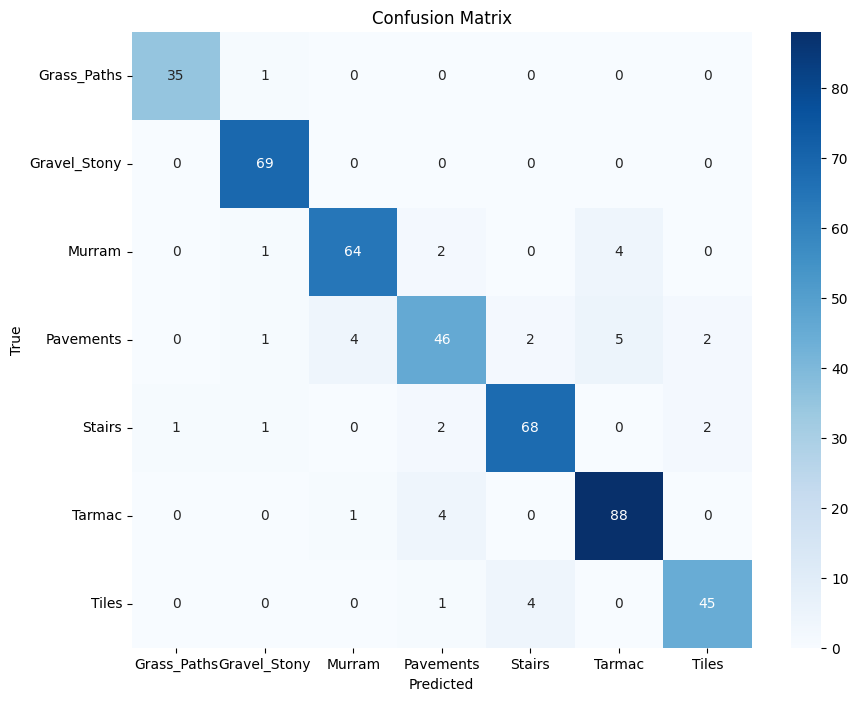


Classification Report:

              precision    recall  f1-score   support

 Grass_Paths       0.97      0.97      0.97        36
Gravel_Stony       0.95      1.00      0.97        69
      Murram       0.93      0.90      0.91        71
   Pavements       0.84      0.77      0.80        60
      Stairs       0.92      0.92      0.92        74
      Tarmac       0.91      0.95      0.93        93
       Tiles       0.92      0.90      0.91        50

    accuracy                           0.92       453
   macro avg       0.92      0.92      0.92       453
weighted avg       0.92      0.92      0.92       453



In [11]:
import shutil

# Predict on validation set
val_data.reset()
y_true = val_data.classes
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Save misclassified images (Optional)
misclassified_dir = os.path.join(model_output_dir, "misclassified")
os.makedirs(misclassified_dir, exist_ok=True)

for i, (pred, true) in enumerate(zip(y_pred, y_true)):
    if pred != true:
        filename = val_data.filenames[i]
        src = os.path.join(val_dir, filename)
        dst_folder = os.path.join(misclassified_dir, f"true_{class_names[true]}_pred_{class_names[pred]}")
        os.makedirs(dst_folder, exist_ok=True)
        shutil.copy(src, os.path.join(dst_folder, os.path.basename(filename)))


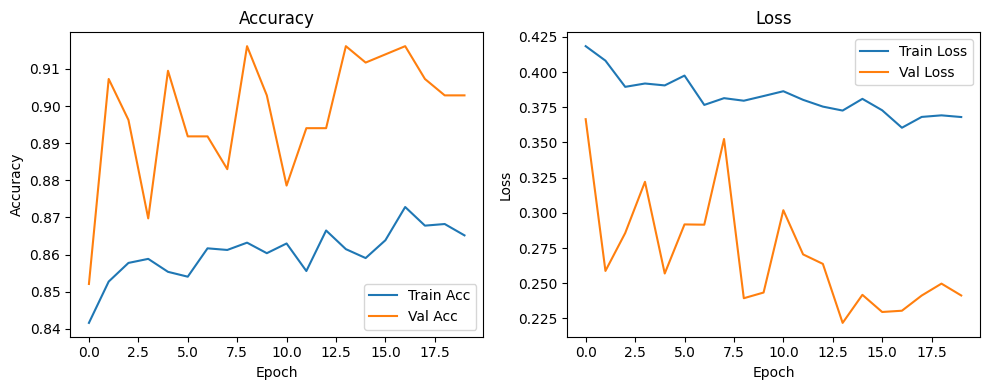

In [12]:
# ========================
# === Plot Performance ===
# ========================
# --- Cell 10 : Plot Accuracy and Loss ---
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
